# Lab 6 - EDA with Clustering

### Jackson Rolando

## Part 1 - Load and Transform the Data

We'll load the data, split it into training and testing, transform it into a sparse bag of words matrix, excluding words appearing less than 10 times:

In [1]:
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
objects = []
for file in glob.glob('./email_json/*.json'):
    with open(file) as f:
        objects.append(json.load(f))

df = pd.DataFrame(objects)
df.head()

,category,to_address,from_address,subject,body
0,ham,BREAKINGNEWS Subscribers<BREAKINGNEWS-Subscrib...,BREAKING NEWS<breakingnews@foxnews.com>,FNC Alert,"PELOSI, REID SIGN WAR-SPENDING BILL THAT INCLU..."
1,spam,<theorize@plg.uwaterloo.ca>,"""cschai"" <cschai@syhmco.co.kr>",rtfmub,\n\n\n\n\n\n\n\nwyat\nlnpmoqrkhapibcegd\n\n\n\...
2,spam,"""Theorize"" <theorize@plg.uwaterloo.ca>","""Aegis Capital Group LLC"" <Estela.Burch@smapxs...",Invitation to fill in the vacant position of a...,"\n\n\n\nDear sirs,\nAegis Capital Gro..."
3,spam,warwickktwarwic@speedy.uwaterloo.ca,"""shar Nobis"" <sharNobis@autotradebuyer.co.uk>",Terrific gains possible!,http://s6.bilder-hosting.de/img/7LR4W.jpg\nImp...
4,ham,R-help@stat.math.ethz.ch,jessica.gervais@tudor.lu,[R] time serie generation,"\nDear all,\n\nI would like to generate a regu..."


In [3]:
df.category = df.category.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   category      63542 non-null  category
 1   to_address    63141 non-null  object  
 2   from_address  63542 non-null  object  
 3   subject       63410 non-null  object  
 4   body          63542 non-null  object  
dtypes: category(1), object(4)
memory usage: 2.0+ MB


In [4]:
# from sklearn.model_selection import train_test_split

# data = df.drop(['category'], axis=1)
# labels = df['category']

# train, test, train_label, test_label = train_test_split(data, labels, test_size=.15)


# train.to_json('./data/train_data.json')
# test.to_json('./data/test_data.json')
# train_label.to_json('./data/train_label.json')
# test_label.to_json('./data/test_label.json')

train = pd.read_json('./data/train_data.json')
test = pd.read_json('./data/test_data.json')
train_label = pd.read_json('./data/train_label.json', typ='series')
test_label = pd.read_json('./data/test_label.json', typ='series')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, min_df=10)
train_feat_mat = vectorizer.fit_transform(train.body)

test_feat_mat = vectorizer.transform(test.body)

print(train_feat_mat.shape)
print(test_feat_mat.shape)

(54010, 29326)
(9532, 29326)


## Part 2 - Clustering the Emails

I chose KMeans, as the clusters should be linearly separable. Knowing how the data looks from the previous lab, the density of the data, as well as the mixture of ham vs spam, seems to change throughout the space, so I'll keep the number of clusters high.

We'll run SVD dimension reduction to bring the columns down to 10, then cluster the data and make a map from cluster to label for predictions:

[0.05780993 0.02786145 0.01750974 0.01319702 0.01363418 0.01094181
 0.01059009 0.01014235 0.00814024 0.0079912 ]


<BarContainer object of 10 artists>

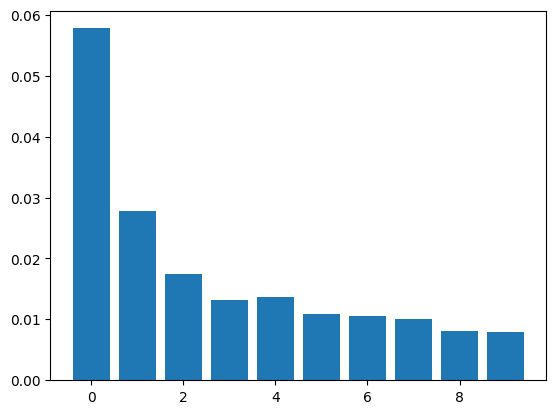

In [6]:
from sklearn.decomposition import TruncatedSVD

condenser = TruncatedSVD(n_components=10)
train_condensed_mat = condenser.fit_transform(train_feat_mat)

test_condensed_mat = condenser.transform(test_feat_mat)

print(condenser.explained_variance_ratio_)
plt.bar(np.arange(condenser.explained_variance_ratio_.size), condenser.explained_variance_ratio_)

In [104]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=20)

train_clusters = clusterer.fit_predict(train_condensed_mat[:, 0:2])

test_clusters = clusterer.predict(test_condensed_mat[:, 0:2])

/home/rolo/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [105]:
np.unique(train_clusters)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

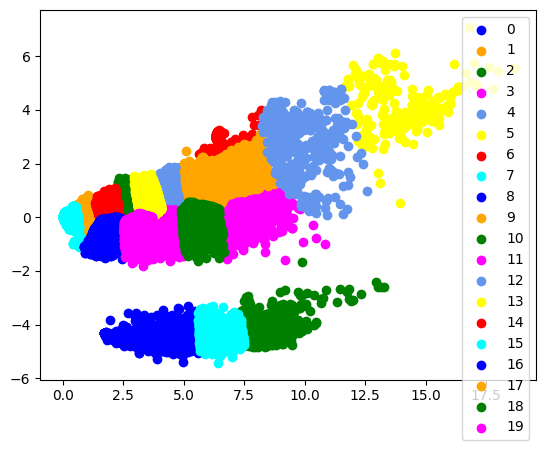

In [109]:
colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'magenta', 4: 'cornflowerblue', 5: 'yellow', 6: 'red', 7: 'aqua'}

fig, ax = plt.subplots()
for cluster_num in np.unique(train_clusters):
    indices = np.where(train_clusters == cluster_num)
    ax.scatter(train_condensed_mat[indices, 0], train_condensed_mat[indices, 1], label=cluster_num, c=colors[cluster_num % len(colors)])
ax.legend()
plt.show()

We'll check the counts of ham vs spam in each of the clusters:

In [110]:
total = train_label.shape[0]
ham_num = (train_label == 'ham').sum()
format_percent = '%.2f'%(100 * ham_num / total)
print(f'total: {total} - ham: {ham_num} - {format_percent}%\n')

cluster_hams = {}
for clust in np.unique(train_clusters):
    total = train_clusters[train_clusters == clust].shape[0]
    ham_num = train[(train_clusters == clust) & (train_label == 'ham')].shape[0]
    
    dec_ham = ham_num / total
    cluster_hams[clust] = dec_ham

    format_percent = '%.2f'%(100 * dec_ham)
    print(f'cluster {clust}: {total} - ham: {ham_num} - {format_percent}%')


print(f'\n{cluster_hams}')

clust_label_map = {}
for clust, percent_ham in cluster_hams.items():
    clust_label_map[clust] = 'ham' if percent_ham > 0.5 else 'spam'

print(f'\n{clust_label_map}')

def cluster_predict(condensed_mat):
    clusters = clusterer.predict(condensed_mat)

    mapped = np.vectorize(lambda cluster_num: clust_label_map.get(cluster_num))(clusters)

    return mapped

train_predicted = cluster_predict(train_condensed_mat[:, 0:2])
train_predicted

total: 54010 - ham: 19581 - 36.25%

cluster 0: 1857 - ham: 1857 - 100.00%
cluster 1: 5814 - ham: 986 - 16.96%
cluster 2: 5567 - ham: 826 - 14.84%
cluster 3: 706 - ham: 694 - 98.30%
cluster 4: 3673 - ham: 542 - 14.76%
cluster 5: 216 - ham: 186 - 86.11%
cluster 6: 753 - ham: 73 - 9.69%
cluster 7: 8343 - ham: 1423 - 17.06%
cluster 8: 1342 - ham: 1342 - 100.00%
cluster 9: 1670 - ham: 326 - 19.52%
cluster 10: 441 - ham: 441 - 100.00%
cluster 11: 2077 - ham: 1979 - 95.28%
cluster 12: 375 - ham: 297 - 79.20%
cluster 13: 5745 - ham: 756 - 13.16%
cluster 14: 5568 - ham: 516 - 9.27%
cluster 15: 1293 - ham: 1293 - 100.00%
cluster 16: 1993 - ham: 1840 - 92.32%
cluster 17: 2749 - ham: 605 - 22.01%
cluster 18: 1500 - ham: 1385 - 92.33%
cluster 19: 2328 - ham: 2214 - 95.10%

{0: 1.0, 1: 0.1695906432748538, 2: 0.14837434884138676, 3: 0.9830028328611898, 4: 0.14756329975496868, 5: 0.8611111111111112, 6: 0.09694555112881806, 7: 0.17056214790842622, 8: 1.0, 9: 0.19520958083832335, 10: 1.0, 11: 0.95281656

array(['spam', 'ham', 'spam', ..., 'spam', 'spam', 'ham'], dtype='<U4')

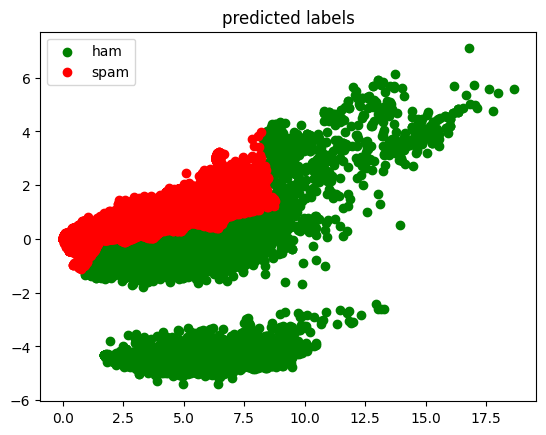

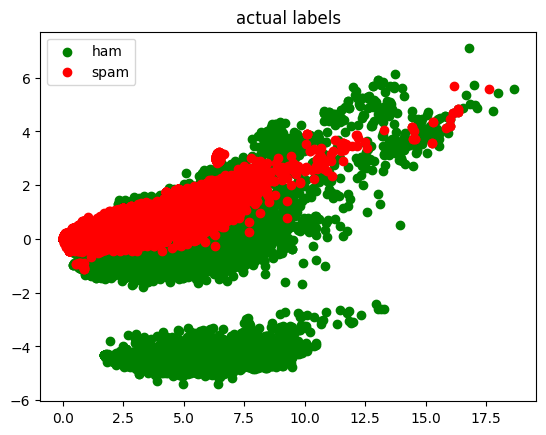

In [111]:
colors = {'ham': 'green', 'spam': 'red'}

fig, ax = plt.subplots()
for label in np.unique(train_label):
    indices = np.where(train_predicted == label)
    ax.scatter(train_condensed_mat[indices, 0], train_condensed_mat[indices, 1], label=label, c=colors[label])
ax.set_title('predicted labels')
ax.legend()
plt.show()

fig, ax = plt.subplots()
for label in np.unique(train_label):
    indices = np.where(train_label == label)
    ax.scatter(train_condensed_mat[indices, 0], train_condensed_mat[indices, 1], label=label, c=colors[label])
ax.set_title('actual labels')
ax.legend()
plt.show()

With 20 clusters, the algorithm was able to generalize the area in which most spam emails occur. Now we'll predict on the test data and make a confusion matrix based on its results. 

9532
2487


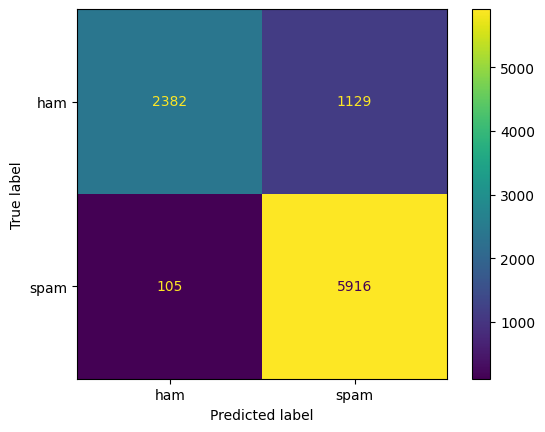

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_cluster_preds = cluster_predict(test_condensed_mat[:, 0:2])
print(test_cluster_preds.shape[0])
print((test_cluster_preds == 'ham').sum())

cm = confusion_matrix(test_label, test_cluster_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])

disp.plot()
plt.show()

In [124]:
print(f'{(2382 + 5916)} out of {(2382 + 5916 + 1129 + 105)} predicted correctly')

8298 out of 9532 predicted correctly


It looks like the clustering performed well for the test set. 

## Part 3 - Calculating Document Frequencies of Words

In [129]:
ham_mat = train_feat_mat[train_predicted == 'ham']
spam_mat = train_feat_mat[train_predicted == 'spam']

from scipy.sparse import csc_matrix
ham_mat = csc_matrix(ham_mat)
spam_mat = csc_matrix(spam_mat)

In [134]:
ham_word_cnts = ham_mat.sum(axis=0)
print(ham_word_cnts.shape)
spam_word_cnts = spam_mat.sum(axis=0)
print(spam_word_cnts.shape)

(1, 29326)
(1, 29326)


In [149]:
def print_freqs(word):
    word_ind = vectorizer.vocabulary_[word]
    freq = ham_word_cnts[0, word_ind]
    total = ham_mat.shape[0]
    format_percent = '%.2f'%(100 * freq / total)
    print(f'{word}:\n  ham: {freq} - appears in {format_percent}% of ham-predicted documents')

    freq = spam_word_cnts[0, word_ind]
    total = spam_mat.shape[0]
    format_percent = '%.2f'%(100 * freq / total)
    print(f'  spam: {freq} - appears in {format_percent}% of spam-predicted documents\n')

In [150]:
print_freqs('love')
print_freqs('works')
print_freqs('different')

love:
  ham: 355 - appears in 2.51% of ham-predicted documents
  spam: 1365 - appears in 3.42% of spam-predicted documents

works:
  ham: 1407 - appears in 9.96% of ham-predicted documents
  spam: 1179 - appears in 2.96% of spam-predicted documents

different:
  ham: 1497 - appears in 10.60% of ham-predicted documents
  spam: 936 - appears in 2.35% of spam-predicted documents



## Part 4 - Find Enriched Words with Statistical Testing

In [222]:
import scipy.stats as stats

enriched_in_0 = np.vectorize(lambda spam_word_cnt, ham_word_cnt: stats.binom_test(ham_word_cnt, ham_mat.shape[0], (spam_word_cnt / spam_mat.shape[0]), alternative='greater'))(spam_word_cnts, ham_word_cnts)
enriched_in_1 = np.vectorize(lambda spam_word_cnt, ham_word_cnt: stats.binom_test(spam_word_cnt, spam_mat.shape[0], (ham_word_cnt / ham_mat.shape[0]), alternative='greater'))(spam_word_cnts, ham_word_cnts)

In [224]:
print(enriched_in_0.shape)
print(enriched_in_1.shape)

(1, 29326)
(1, 29326)


In [228]:
word = 'works'
ind = vectorizer.vocabulary_[word]
print(f'{word}: \nin 0: {enriched_in_0[0, ind]}')
print(f'in 1: {enriched_in_1[0, ind]}')
print()

word = 'love'
ind = vectorizer.vocabulary_[word]
print(f'{word}: \nin 0: {enriched_in_0[0, ind]}')
print(f'in 1: {enriched_in_1[0, ind]}')
print()

works: 
in 0: 0.0
in 1: 0.9999999999999999

love: 
in 0: 0.9999999997999472
in 1: 1.8293020464383167e-28



Works is enriched in 0, and love is enriched in 1. So, works is more often in ham, and love is more often in spam.

In [259]:
words_enriched_in_0 = []
words_enriched_in_1 = []
for word, index in vectorizer.vocabulary_.items():
    if(word.isalpha()):
        p_0 = enriched_in_0[0, index]
        p_1 = enriched_in_1[0, index]
        ham_cnt = ham_word_cnts[0, index]
        spam_cnt = spam_word_cnts[0, index]
        words_enriched_in_0.append((p_0, word, ham_cnt))
        words_enriched_in_1.append((p_1, word, spam_cnt))

In [256]:
print('enriched in 0:')
for word in sorted(words_enriched_in_0, key=lambda x: x[0])[0:200]:
    print(word[1])

enriched in 0:
hello
new
and
http
www
with
need
for
any
this
to
try
be
me
in
the
kernel
module
so
can
use
my
dectalk
linux
running
that
from
am
there
would
have
some
something
help
just
files
ve
using
working
want
could
of
same
thanks
do
mail
speakup
mailing
list
braille
uwo
speech
mailman
listinfo
which
or
not
please
does
system
also
get
it
at
if
code
is
original
message
bounces
stat
math
ethz
ch
mailto
on
sent
subject
question
hi
context
statistics
other
example
as
mean
read
but
alternative
html
version
deleted
https
posting
guide
project
org
provide
commented
minimal
self
contained
reproducible
an
when
plot
format
way
wed
may
wrote
how
library
matrix
pairwise
dataset
output
each
function
following
like
problem
file
advance
university
brian
ripley
stats
ox
professor
applied
oxford
tel
fax
written
cc
cheers
lists
ibiblio
where
make
used
possible
root
rev
work
works
learn
what
error
unsubscribe
view
source
two
user
os
data
first
trouble
pl
prostoalex
writes
looks
instead
then
method
ad

In [257]:
print('enriched in 1:')
for word in sorted(words_enriched_in_1, key=lambda x: x[0])[0:200]:
    print(word[1])

enriched in 1:
visit
our
online
shipping
worldwide
lorena
your
loan
refinance
credit
ready
lenders
established
lowest
payments
thay
unhappy
lover
safest
pnis
anywhere
millions
men
enhan
ement
hes
atches
deliver
product
unreal
dis
ounts
pybal
hk
his
he
producttestpanel
speedy
uwaterloo
sternshirt
buy
high
quality
price
us
photoshop
canadian
sterling
thrive
industrious
fasten
delivery
customer
day
instructed
money
gram
instruct
literacy
sociability
expenses
chargers
traveling
vacancy
sydneycarcentre
vacancies
glad
yours
rcs
howstuffworks
prices
suite
click
younger
low
news
instant
premiere
safe
fast
alerts
chose
discounts
meds
oem
packing
booklets
macromedia
adobe
acrobat
corel
grafix
illustrator
ableton
gigabook
borland
gervasio
her
centrecar
viagra
erection
sex
life
suffer
difficulties
maintaining
erectile
dysfunction
lotteryagent
lotto
renown
powerballmegamillionseuromillions
lotterylotto
ennis
wakes
fiv
poo
shook
choky
mornin
arched
sheep
tent
lagging
commutin
aint
wouldnt
bein
mrs
s

## Reflection Questions
1. There are many words in the English language that are necessary for basic sentence sturcture, like 'the', 'and', 'a'... that are sure to appear in most emails, regardless of if it's ham or spam. The separate cluster consists of words that were not seen in spam at all, potentially being terms directly related to specified work topics, maybe people's names, or just overall great vocabulary not usually seen in foreign-written spam emails. 
2. In my clustering, there is both ham and spam in most of the clusters. I tried to achieve a tighter fitting clustering to the data. There were a few clusters which covered the bottom section of points, which only contained ham messages. The mapping could be changed to make sure that ONLY these clusters are mapped to ham. 
3. The ham messages contained a lot of 'advertisey' language, trying to make whatever they're talking about seem too good to be true. The ham messages seem to be more topical, and sometimes contain typos. 

In [261]:
train[train_predicted == 'ham'][0:25]

,to_address,from_address,subject,body
42791,"""Speakup is a. screen review system for Linux....",Radical NetSurfer <radsurfer@yahoo.com>,Help with dtpc.o for Centos 5,One reason I rejoined this group was to try to...
34315,"""Y G"" <gatemaze@gmail.com>, <r-help@stat.math....","""Leeds, Mark \(IED\)"" <Mark.Leeds@morganstanle...",Re: [R] general question about use of list,it's also not unbiased.\n\n\n\n-----Original M...
54248,Felicity Jones <felicity.jones@stanford.edu>,Prof Brian Ripley <ripley@stats.ox.ac.uk>,Re: [R] sizing and saving graphics in R,"Why not plot directly to a bitmapped format, u..."
35193,cc-community@lists.ibiblio.org,Andy Kaplan-Myrth <techlaw@uottawa.ca>,[cc-community] Podcasting Legal Guide for Canada,When Creative Commons published their Podcasti...
37793,avcooper@flax9.uwaterloo.ca,slashdot@slashdot.org,[Slashdot] Stories for 2007-05-23,==============================================...
32395,r-help@stat.math.ethz.ch,(Ted Harding) <ted.harding@nessie.mcc.ac.uk>,Re: [R] to draw a smooth arc,This thread prompts me to ask about something ...
56651,"""Christopher R. Hertel"" <crh@ubiqx.mn.org>",Jeremy Allison <jra@samba.org>,Re: Preserving NTFS permissions.,"On Wed, Jun 20, 2007 at 11:44:21AM -0500, Chri..."
30652,perl6-internals@perl.org,allison@cvs.develooper.com,[svn:parrot-pdd] r18213 - trunk/docs/pdds,Author: allison\nDate: Sat Apr 14 17:06:35 200...
49556,Chabot Denis <chabotd@globetrotter.net>,Prof Brian Ripley <ripley@stats.ox.ac.uk>,Re: [R] Reducing the size of pdf graphics file...,>From the help page\n\n 'pdf' writes unco...
434,Christoph Buser <buser@stat.math.ethz.ch>,"""Daniel Tahin"" <e0226781@student.tuwien.ac.at>",Re: [R] Preconditions for a variance analysis,"Thanx for your answer. I don't have the book, ..."


In [262]:
train[train_predicted == 'spam'][0:25]

,to_address,from_address,subject,body
7375,theorize@plg.uwaterloo.ca,"""Darla Blanco"" <p4L4MLJ@fanciers.com>",diagnoses malawi commonality__,"Hello,\n\nVisit our new online store and save...."
22780,theorize@plg.uwaterloo.ca,"""Most languages"" <stzezxh@ehotelier.com>",Loan for a low month payment,"\n\n\n\n\n\nThank you for your loan request, w..."
63457,"""theorize"" <theorize@plg.uwaterloo.ca>","""Fabian Jewell"" <tiqannada@hostune.com>",you afton go imlaystown,Does Size Matter'?\n_____\n\n60% of WOMEN said...
26257,"""Subscriber"" <producttestpanel@speedy.uwaterlo...","""Shipment Notice #HL-225825"" <Jenny@strongimpr...",Brand Samples shipping to your area =?UTF8?Q?=...,ttp://www.lynxtrack.com/afclick.php?o=4343&b=d...
58300,the00@plg2.math.uwaterloo.ca,"""Kimberley Mora"" <the00@plg2.math.uwaterloo.ca>",Domingo Buy your loved one Glashutte,\nHighest qualities Replic Watches now !\n\n\n...
41544,producttestpanel@flax9.uwaterloo.ca,CollegePlanner <CollegePlanner@massiveservices...,"adf, 10k scholarship giveaways - next drawing ...",\n\n251839499 FAIR USE of Philadelphia Cit...
1519,"""Gnitpick"" <gnitpick@flax9.uwaterloo.ca>","""Sydney Car Centre"" <qaubm@altern.org>",Account managers vacant position in the Sydney...,\n\n\n\nWhile we may have high ...
32192,<ktwarwic@flax9.uwaterloo.ca>,"""HowStuffWorks"" <newsletter@howstuffworks.com>","HowStuffWorks Lifestyle Newsletter May 10, 2007","\nhowstuffworks® | lifestyle May 10, 2007\nRSS..."
7250,<theorize@plg.uwaterloo.ca>,"""Guadalupe Rhodes"" <ifuuow@boardiq.com>",Global sale before new project opening!,\n\n\n\n\n\n\n\nDear valued member.\n\nExtra d...
13006,<gnitpick@flax9.uwaterloo.ca>,"""Zachary Adams"" <Tristan.Richardson@adultactio...",Zachary Adams get it!,"OEM software means no CD/DVD, no packing case,..."


4. and 
5. It looks like the R newsletter was more the in the ham category, and the college emails were much more spammy. We can tell these apart by the email addresses, containing 'uwaterloo' in very many of the spam emails. 